# Exercise 2.3: *Explain* the predictions of a CNN
This notebook provides an implementation for GradCAM as presented in [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391).
GradCAM provides us with a way to look into what particular parts of the image influenced the whole model’s decision for a specifically assigned label. The main idea exploits the gradient information. It starts with finding the gradient of the most dominant logit with respect to the latest activation map in the model.  We can interpret this as some encoded features that ended up activated in the final activation map persuaded the model as a whole to choose that particular logit. The gradients are then pooled channel-wise, and the activation channels are weighted with the corresponding gradients, yielding the collection of weighted activation channels. By inspecting these channels, we can tell which ones played the most significant role in the decision of the class.

### First we trained a model on CIFAR10 to be evaluated
#### Standard imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torch.utils.tensorboard import SummaryWriter
import wandb
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import wandb
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor
import cv2

#### Training hyperparameters.

In [2]:
batch_size = 64
lr = 0.01
momentum=0.9
weight_decay=1e-04
epochs = 25
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    device = torch.device("cuda") # to use the GPU
else:
    device = torch.device("cpu")

#### Data preparation

Dataset loading, validation splitting code for CIFAR10.

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
# create a split for train/validation. We can use early stop
trainset, valset = torch.utils.data.random_split(dataset, [40000, 10000])  # train (40000 images) e validation (10000 images)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          drop_last=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                          drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


#### Training and evaluation Functions 

Training, evaluation, and plotting code.

In [4]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=False):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = criterion(logits, ys)
        loss.backward()
        opt.step()   
        losses.append(loss.item())
    return loss.item()

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    test_loss = 0
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        output = model(xs)
        preds = torch.argmax(output, dim=1)
        test_loss += F.cross_entropy(output, ys.to(device)).item()
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy()) 

    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))


# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')
    

#### Basic code for 3x3 and 1x1 convolutions

In [5]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

#### Convolutional Block for ConvNet and ResNet

In [6]:
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        skip: bool = False
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.skip = skip
        self.downsample = None
        if self.skip:
            self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity
        
        out = self.relu(out)

        return out

#### Main model backbone

In [7]:
class ConvNet(nn.Module):
    def __init__(
        self,
        layers: List[int],
        num_classes: int = 10,
        zero_init_residual: bool = False,
        skip: bool = False,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.skip = skip
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False),
            norm_layer(self.inplanes),
            nn.ReLU(inplace=True))
        self.layer1 = self._make_layer(24, layers[0])
        self.layer2 = self._make_layer(48, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(96, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(192, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(192 * BasicBlock.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * BasicBlock.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * BasicBlock.expansion, stride),
                norm_layer(planes * BasicBlock.expansion),
            )

        layers = []
        layers.append(
            BasicBlock(
                self.inplanes, planes, stride, downsample, norm_layer, self.skip)
        )
        self.inplanes = planes * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(
                BasicBlock(
                    self.inplanes,
                    planes,
                    norm_layer=norm_layer,
                    skip=self.skip
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [8]:
def _convnet(
    layers: List[int],
    num_classes: int,
    skip: bool = False,
    **kwargs: Any,
) -> ConvNet:

    model = ConvNet(layers, num_classes, False, skip, **kwargs)

    return model

#### Models
We applied GradCAM on a ConvNet model made up of [1, 1, 2, 1] blocks with increasing dimensions [24, 48, 96, 192].

In [9]:
def small_convnet(num_classes) -> ConvNet:
    return _convnet([1, 1, 2, 1], num_classes, skip=False)
def small_resnet(num_classes) -> ConvNet:
    return _convnet([2, 2, 4, 2], num_classes, skip=True)

In [10]:
convnet = small_convnet(10)
print(convnet)

ConvNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(48, 48, kernel_s

In [11]:
resnet = small_resnet(10)
print(resnet)

ConvNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [11]:
convnet = small_convnet(10).to(device)
optimizer = torch.optim.SGD(convnet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

Epoch:  0 	Loss:  1.1759099960327148 	 Val Acc:  0.4404


Epoch:  1 	Loss:  1.0921499729156494 	 Val Acc:  0.6094


Epoch:  2 	Loss:  0.8024080395698547 	 Val Acc:  0.6744


Epoch:  3 	Loss:  0.6916362047195435 	 Val Acc:  0.7331


Epoch:  4 	Loss:  0.770905613899231 	 Val Acc:  0.7545


Epoch:  5 	Loss:  0.6693576574325562 	 Val Acc:  0.7487


Epoch:  6 	Loss:  0.9677740931510925 	 Val Acc:  0.7794


Epoch:  7 	Loss:  0.6405037641525269 	 Val Acc:  0.79


Epoch:  8 	Loss:  0.5057550668716431 	 Val Acc:  0.8027


Epoch:  9 	Loss:  0.5558398365974426 	 Val Acc:  0.8009


Epoch:  10 	Loss:  0.7113592624664307 	 Val Acc:  0.8204


Epoch:  11 	Loss:  0.4360276460647583 	 Val Acc:  0.8243


Epoch:  12 	Loss:  0.7503141760826111 	 Val Acc:  0.8183


Epoch:  13 	Loss:  0.3289914131164551 	 Val Acc:  0.8302


Epoch:  14 	Loss:  0.518165647983551 	 Val Acc:  0.825


Epoch:  15 	Loss:  0.2824261784553528 	 Val Acc:  0.8352


Epoch:  16 	Loss:  0.372333288192749 	 Val Acc:  0.8399


Epoch:  17 	Loss:  0.35966816544532776 	 Val Acc:  0.8426


Epoch:  18 	Loss:  0.3777752220630646 	 Val Acc:  0.8474


Epoch:  19 	Loss:  0.2962604761123657 	 Val Acc:  0.8433


Epoch:  20 	Loss:  0.2046871930360794 	 Val Acc:  0.8473


Epoch:  21 	Loss:  0.3088526725769043 	 Val Acc:  0.8546


Epoch:  22 	Loss:  0.44791194796562195 	 Val Acc:  0.8471


Epoch:  23 	Loss:  0.2582497000694275 	 Val Acc:  0.8546


Epoch:  24 	Loss:  0.4267876446247101 	 Val Acc:  0.8544


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.920     0.826     0.870      1000
           1      0.953     0.929     0.941      1000
           2      0.761     0.867     0.811      1000
           3      0.696     0.800     0.744      1000
           4      0.851     0.831     0.841      1000
           5      0.887     0.707     0.787      1000
           6      0.854     0.916     0.884      1000
           7      0.925     0.873     0.898      1000
           8      0.877     0.948     0.911      1000
           9      0.948     0.917     0.932      1000

    accuracy                          0.861     10000
   macro avg      0.867     0.861     0.862     10000
weighted avg      0.867     0.861     0.862     10000


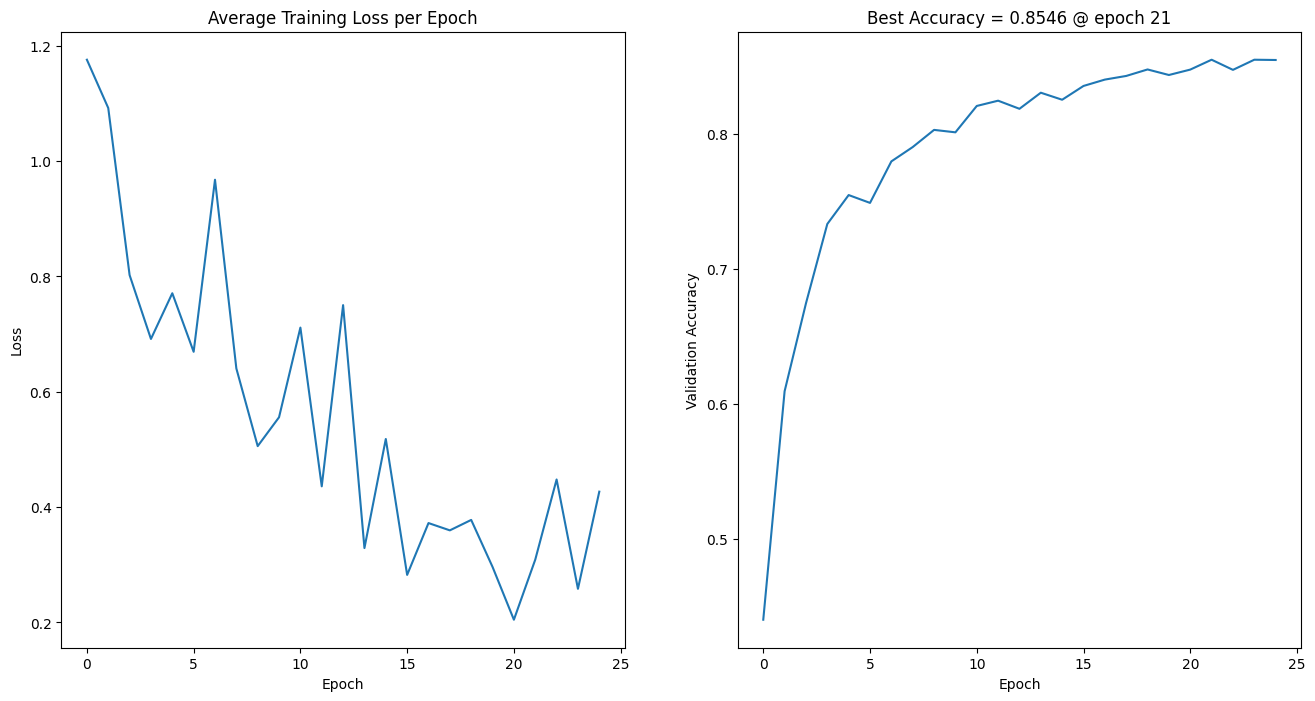

In [12]:
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(convnet, trainloader, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(convnet, valloader, device=device)
    losses_and_accs.append((loss, val_acc))
    print('Epoch: ', epoch, '\tLoss: ', loss, '\t Val Acc: ', val_acc)
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(convnet, testloader, device=device)[1]}')
    

## GradCAM

First we implement the GradCAM which returns the saliency map that we are interested in. It receives in input a model and a target_layer of the network to study the saliency map. Firstly we hook both the activations and the gradients of the target layer. This is necessary since PyTorch only caches the gradients of the leaf nodes in the computational graph, such as weights, biases and other parameters, the gradients of the output with respect to the activations are merely intermediate values and are discarded as soon as the gradient propagates through them on the way back.

In [22]:
class GradCAM(object):
   
    def __init__(self, model, target_layer, input_size, verbose=False):
        """
        Args:
            input: model architecture to perform GradCAM
            target_layer: the last layer of the network where we apply GradCAM to obtain the saliency map
        """
        self.model_arch = model

        self.gradients = dict()
        self.activations = dict()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None


        target_layer.register_forward_hook(forward_hook) # Save the activations of the target layer during forward pass
        target_layer.register_backward_hook(backward_hook) # Save gradients of the target layer during backward pass 

        if verbose:
            device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
            self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
            print('saliency_map size :', self.activations['value'].shape[2:])


    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)




In [14]:
def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]

    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result


In [28]:
# get the image from the dataloader
img, _ = next(iter(testloader))
img = img[10, :,:, :].unsqueeze(0)

In [16]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

In [29]:
convnet.eval()
gradcam = GradCAM(model=convnet, target_layer=convnet.layer4[0].bn2, input_size=(32, 32), verbose=True)

images = []

mask, _ = gradcam(img.to(device))
heatmap, result = visualize_cam(mask.cpu(), unorm(img.cpu()))

saliency_map size : torch.Size([4, 4])


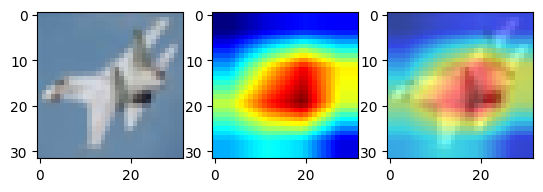

In [31]:
_, axarr = plt.subplots(1,3)
axarr[0].imshow(np.transpose(img.squeeze().numpy(), (1, 2, 0)))
axarr[1].imshow(np.transpose(heatmap, (1, 2, 0)))
axarr[2].imshow(np.transpose(result, (1, 2, 0)))
plt.show()